<a href="https://colab.research.google.com/github/akanshkatyayan/FashionMNIST_MLPNetwork/blob/master/NNandDL_Coursework1_AkanshKatyayan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

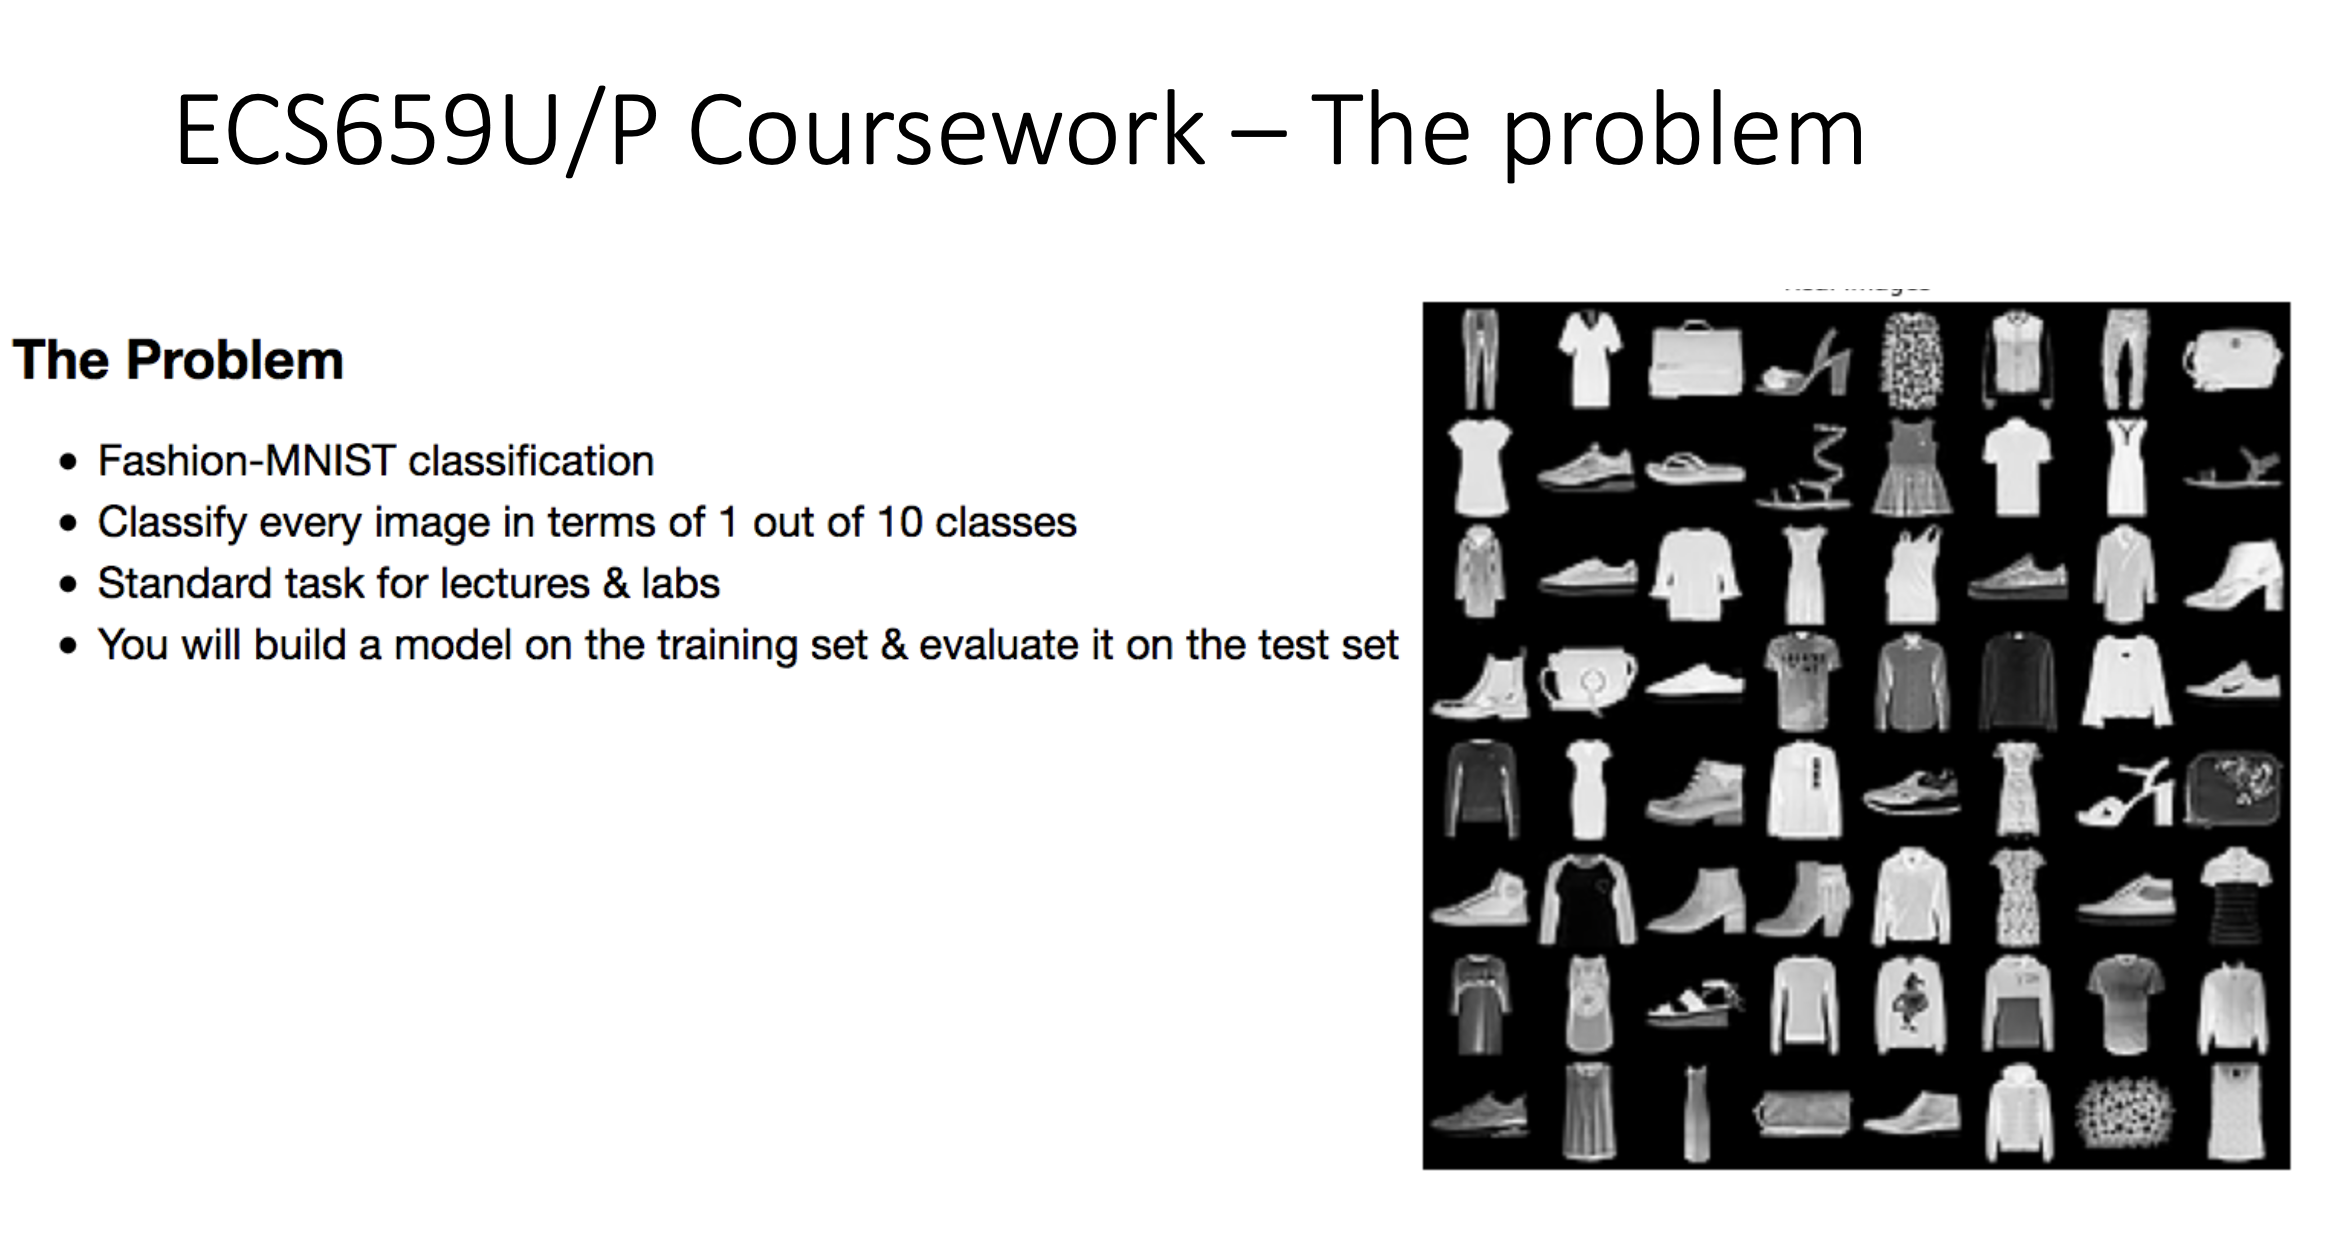

# Import Dependencies

my_utils.py should be added at the below address:
/content/gdrive/MyDrive/Colab Notebooks/

In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/') # my_utils have been uploaded at this location

Mounted at /content/gdrive


In [ ]:
import my_utils as mu # importing my_utils as provided in labs in NN and DL Course
import torch
from torch import nn
from IPython import display
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

# Using cuda gpu to train the models
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


# Citations

**1: my_utils.py** provided as part of Lab work in ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

# Pipeline

* The pipeline consists of:
    1. Read the dataset and create the appropriate dataloaders. 
    1. Create and initialise the model - Stem, Backbone and Classifier
    1. Create the loss and the optimizer.
    1. Create the training function.
    1. Train and evaluate the model.


# Part 1: Read Dataset and Create Dataloaders


Using my_utils provided in course labs to load MNIST Fashion dataset which contains Gray scale images of different fashion items.
Information of the Dataset:

1. **Title**: MNIST Fashion Dataset

2. Sources:
   (a) **Origin**:  This dataset has been taken from the PyTorch using my_utils load_data_fashion_mnist function.

3. Relevant Information:
   Contains gray scale images of 10 labels as below:

   1. t-shirt
   2. trouser
   3. pullover
   4. dress
   5. coat
   6. sandal
   7. shirt
   8. sneaker
   9. bag
   10. ankle boot

In [ ]:
# Batch Size to process the Images
batch_size = 256

# Load train and test data from Fashion MNIST dataset of Torchvision library by calling below function defined in my_utils.py file
# Data Loaders are defined in the my_utils 

train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

In [ ]:
# Check number of data samples

print("Number of Training Images: {}".format(len(train_iter.dataset)))
print("Number of Test Images: {}".format(len(test_iter.dataset)))


Number of Training Images: 60000
Number of Test Images: 10000


In [ ]:
# Using next(iter) to process images in Batches
images, labels = next(iter(train_iter))
print(type(images))
print("Size of Each Sample: {}".format(images.shape))

<class 'torch.Tensor'>
Size of Each Sample: torch.Size([256, 1, 28, 28])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3dab932d0>,
      dtype=object)

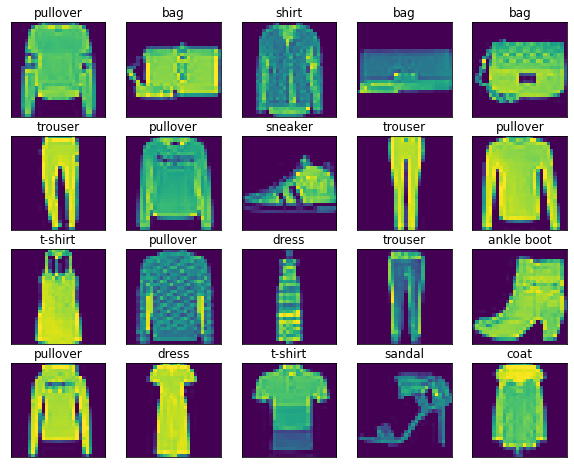

In [ ]:
# Sample Images using show_images function in my utils
mu.show_images(images[0:20].reshape(20, 28, 28), 4, 5, titles=mu.get_fashion_mnist_labels(labels), scale=2)

Size of Each Image: torch.Size([1, 28, 28])
Size of the image after Squeezing: torch.Size([28, 28])


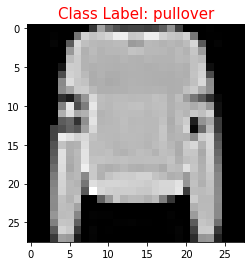

In [ ]:
x = images[0]

# Size of each Image
print("Size of Each Image: {}".format(x.shape))

# Squeeze the first dimension to get an Image of Size 28x28
x = x.squeeze(dim=0)

print("Size of the image after Squeezing: {}".format(x.shape))
label_names = mu.get_fashion_mnist_labels(labels)

# Sample Image

plt.figure(figsize=(4,4)).tight_layout()
plt.title(f"Class Label: {label_names[0]}", fontsize = 15, color='r')
plt.imshow(x.numpy(), cmap='gray')
plt.show()

### Test Patching an Image. 

Image is divided into small patches and each patch is then processed individually. Below we are using unfold method of pytorch to create a patch of size 4x4 by dividing the 28x28 image on both the dimensions.

unfold 1 divides an image in 7x4 on x dimension and similarly unfold 2 divides an image in 7x4 on y dimension resulting in 7x7 = 49 patches of 4x4 Image size.

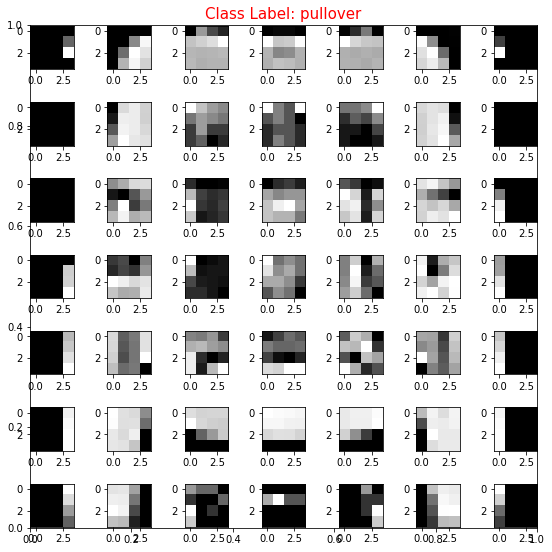

In [ ]:
# Sample Image
sample_image = images[0]

# Size of the patched Image 4x4
patch_width = 4

# Get the number of patches an image will contain
patch_number = (sample_image.shape[1] // patch_width) ** 2

# Convert the image into patches
patches = sample_image.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
patch = patches[0].reshape([-1, patch_width, patch_width])

# Here, let's plot each of the patches
figure = plt.figure(figsize=(8,8));
plt.title(f"Class Label: {label_names[int(0)]}", fontsize = 15, color='r')
columns = sample_image.shape[1]//patch_width;
rows = sample_image.shape[1]//patch_width;
for i in range(len(patch)):
    figure.add_subplot(rows, columns, i+1)
    figure.tight_layout()
    plt.imshow(patch[i].numpy(), cmap='gray')
plt.show()

# Part 2: Create the model

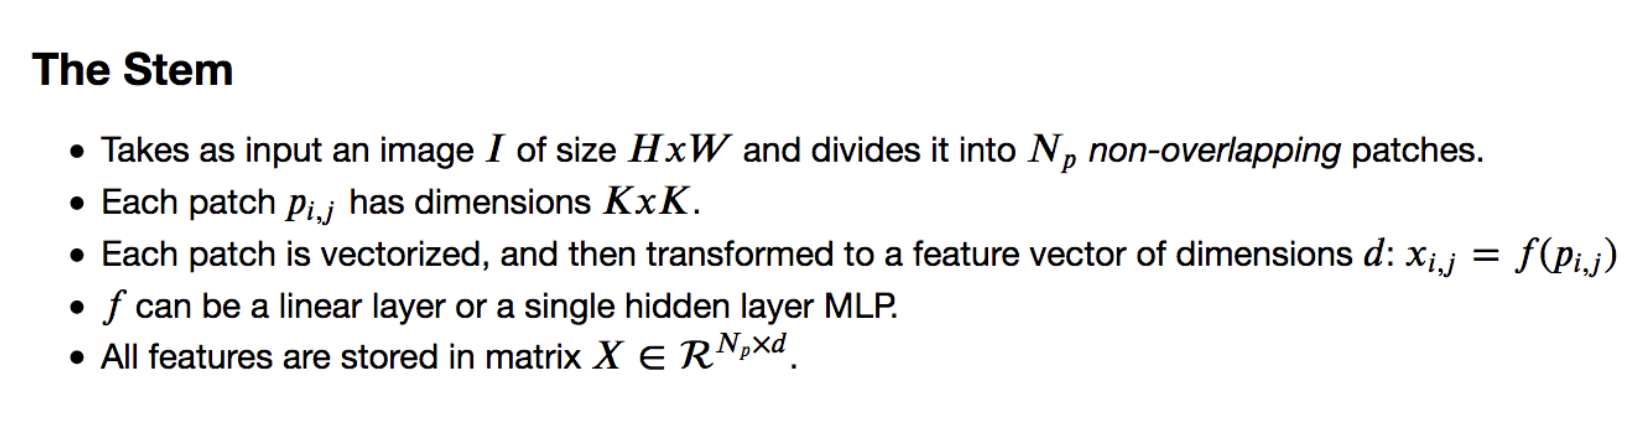


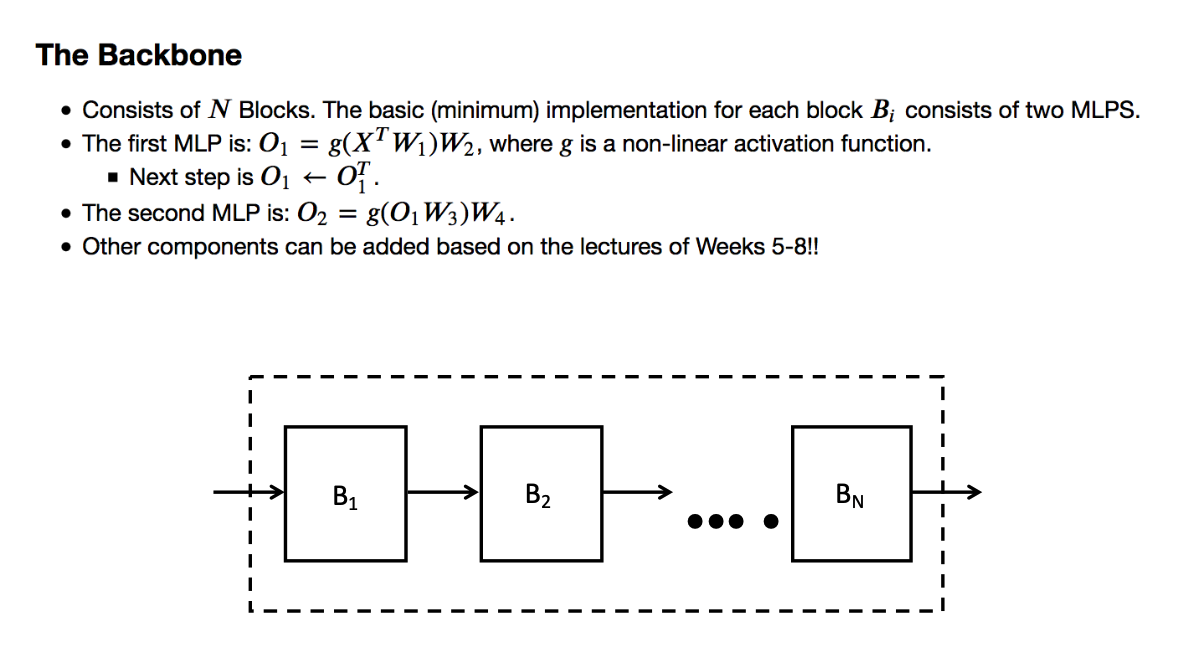

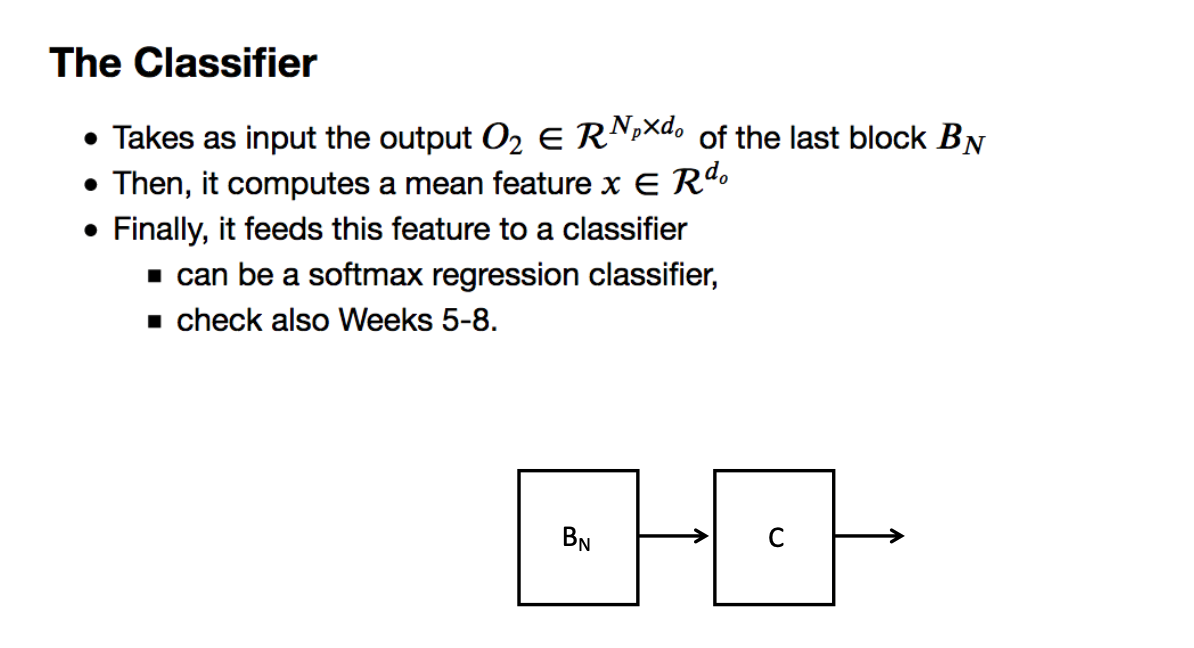

## Patching Images

Below function is defined to patch images as shown above on a sample image. Function takes an image and patch width as an input which is a size of each image. Patch width taken here is 4 to divide each image in 49 patches of 4x4.

In [ ]:
# Create four non-overlapping patches (14x14) of our 28x28 image

def patch_image(input_images, patch_width):
  """
  Function to divide an image in KxK size and vectorize in a dimension d
  """
  # print(input_images.shape[1])
  patch_number = (input_images.shape[1] // patch_width) ** 2
  # Patch Image in KxK size. Here, value of K = 4 x 4

  patches = input_images.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
  
  # print(input_images.size(dim=0))
  # print(patch_number)
  # print(patch_width**2)

  # Vectorize patches to a feature vector
  patches = patches.reshape([input_images.size(dim=0), patch_number, patch_width**2])
  # print(patches.shape)
  return patches

## Initialize Variables

In [ ]:
# Initialize dimensions:

patch_size = 4
stem_weights = {
    'no_of_stem_inputs': patch_size**2, 
    'no_of_stem_outputs': 256
    }
backbone_weights = {
    'num_hidden1': 49,
    'num_hidden2': 256,
    'num_hidden3': 128,
    'num_hidden4': 64,
    'num_hidden5': 32,
    'num_hidden6': 16
}

final_output_size = 10

## Create Model structure

### STEM:

The first component of the model is STEM block which contains two operations.
1. Patching the Images: Here, we are applying a patch function on an input image of 28X28 (total pixels 784) to transform it into smaller patches. On experimentation with different patch sizes of 4, 7, 2 for each image i.e. having 49(4x4 = 16 pixels) pacthes, 16 (7x7 = 49 pixels) patches, 196 (2x2 = 4 pixels) patches respectively. 49 patches of 4x4 siz eeach provided best results in terms of training time, test accuracy. Once, Image is patched into the required size, it is transformed into a verctor of dimension (49,16).

2. Vector created using a patch function is then fed to a linear layer used from torch library. Input size for this Linear layer is the size of the patch i.e 16 and output size of the Linear layer is the size of the hidden layer. Linear layer is used to extract features from the input vector.  After linear layer, Batchnormalization is applied on the output of the linear layer to normalize the hidden layer inputs.

CITE: arXiv:1502.03167
Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

### Backbone:

Bachbone is the part of the model which is a combination of blocks of Hidden layers. Hidden layers are used to extract data (more features)from out input layer and provides the output to the output layer. More number of hidden layers are used to solve more complex problems. 
MLP (Multi-Layer perceptrons) architecture is used in the below model for implementing the hidden layers. 




Below we are using 2 blocks of MLPs. Each MLP block has 2 Linear Layers. Linear layers are used to extract more features from the previous output. Input to the 1st block is the output of the stem block. Firstly, the matrix X is transposed and then fed to a Linear Layer 1. Output of the first linear layer is then activated using ReLU function to overcome vanishing gradient problem. Dropout layer is used to prevent overfitting on the output of the ReLU function. Finally, another Linear Layer is used to extract additional features before feeding it to MLP 2. Output from 1st MLP block O1 is first transposed and then fed to block MLP2 which is similar to MLP 1. 

Similarly, Output of Block 1 is transposed and fed to Block 2 with. MLPS.




### CLassifier:

Classifier performs two operations: 
First, It takes the mean of the learned features from the image. torch.mean function has been used to take the mean of the output from the backbone and then fed to the final classifier layer. Classifier layer has the input size same as the output of the Backbone and output size of the number of classes i.e. 10

Finally, task is to apply the a classifier like softmax regression classifier. CrossEntropy loss function is used therefore, that willconvert the outputs to a probability distribution as in case of Softmax

In [ ]:

class MLPNet(torch.nn.Module):
    def __init__(self, patch_size, stem_weights, backbone_weights, final_output_size):
      super(MLPNet, self).__init__()

      self.patch_size = patch_size # 4 to make image 4x4

      self.stem_input = stem_weights['no_of_stem_inputs'] #16
      self.stem_output = stem_weights['no_of_stem_outputs'] # 256

      self.backbone_num_hidden1 = backbone_weights['num_hidden1'] # 49
      self.backbone_num_hidden2 = backbone_weights['num_hidden2'] # 256
      self.backbone_num_hidden3 = backbone_weights['num_hidden3'] # 128
      self.backbone_num_hidden4 = backbone_weights['num_hidden4'] # 64
      self.backbone_num_hidden5 = backbone_weights['num_hidden5'] # 32
      self.backbone_num_hidden6 = backbone_weights['num_hidden6'] # 16

      self.final_output = final_output_size # 10 label classes

      """
      STEM: Linear Layer with Input (49 x 256)
      """
      
      self.stem_linear_layer = nn.Linear(self.stem_input,  self.stem_output)
      self.batch_normalization_stem = nn.BatchNorm1d(49)

      """
      Backbone: 2 Blocks (B1 and B2). Each Block has 2 MLPs (MLP1 and MLP2)
      Each MLP has 2 Linear Layers
      """

      # Initialize layers for Backbone Block 1

      self.B1_linear1 = nn.Linear(self.backbone_num_hidden1, self.backbone_num_hidden2)
      self.B1_linear2 = nn.Linear(self.backbone_num_hidden2, self.backbone_num_hidden3)
      self.B1_linear3 = nn.Linear(self.backbone_num_hidden2, self.backbone_num_hidden3)
      self.B1_linear4 = nn.Linear(self.backbone_num_hidden3, self.backbone_num_hidden4)
      self.B1_batch_normalization = nn.BatchNorm1d(self.backbone_num_hidden3)
      # Relu Activation Layer
      self.B1_ReLU = nn.ReLU()
      # Dropout Layer
      self.B1_Dropout = nn.Dropout(0.1) 
      
      # Initialize layers for Backbone Block 2
      self.B2_linear1 = nn.Linear(self.backbone_num_hidden3, self.backbone_num_hidden4)
      self.B2_linear2 = nn.Linear(self.backbone_num_hidden4, self.backbone_num_hidden3)
      self.B2_linear3 = nn.Linear(self.backbone_num_hidden4, self.backbone_num_hidden5)
      self.B2_linear4 = nn.Linear(self.backbone_num_hidden5, self.backbone_num_hidden6)
      self.B2_batch_normalization = nn.BatchNorm1d(self.backbone_num_hidden4)
      # Relu Activation Layer
      self.B2_ReLU = nn.ReLU()
      # Dropout Layer
      self.B2_Dropout = nn.Dropout(0.1)

      """
      Classifier: Linear Layer with Output Size 10. Softmax Regression Classifier
      """
      self.classifier = nn.Linear(16, self.final_output)

        
    def forward(self, x):

      # STEM: Patch Images and feed to Linear Layer. Normalize using BatchNorm1D
      x = x.squeeze(dim=1)
      x = patch_image(x, self.patch_size) # Getting output 
      x = self.stem_linear_layer(x)
      x = self.batch_normalization_stem(x)
      
      # Backbone - Block 1 (B1)

      ## Block 1 - MLP 1
      x = torch.transpose(x, 1, 2)

      x = self.B1_linear1(x)
      x = self.B1_ReLU(x)
      x = self.B1_Dropout(x)
      x = self.B1_linear2(x)

      # Output of 1st MLP to be transposed: O1 <- O1.Transpose
      x = torch.transpose(x, 1, 2)

      ## Block 1 - MLP 2
      x = self.B1_linear3(x)
      x = self.B1_ReLU(x)
      x = self.B1_Dropout(x)
      x = self.B1_linear4(x)
      x = self.B1_batch_normalization(x)
      
      # Backbone - Block 2 (B2)

      ## Block 2 - MLP 1
      x = torch.transpose(x, 1, 2)
      x = self.B2_linear1(x)
      x = self.B2_ReLU(x)
      x = self.B2_Dropout(x)
      x = self.B2_linear2(x)

      # Output of 2nd MLP to be transposed: O2 <- O2.Transpose
      x = torch.transpose(x, 1, 2)

      ## Block 2 - MLP 2
      x = self.B2_linear3(x)
      x = self.B2_ReLU(x)
      x = self.B2_Dropout(x)
      x = self.B2_linear4(x)
      x = self.B1_batch_normalization(x)

      
      # Classifier
      # Get the mean of the feature vector of the image
      x = torch.mean(x, 1)
      # Final Linear layer as a classifier
      model_output = self.classifier(x)

      
      return model_output
    

net = MLPNet(patch_size, stem_weights, backbone_weights, final_output_size).to(device)

## Operations on Each Layer:

## Initialize Weights

Model weights have been initialized using the kaiming_normal_ initialization for the linear layers. It uses randomly generated weights and multiplies them by 2/(1+aˆ2)*fan-in (here fan-in is the maximum number of input signals to a single cell). kaimining_normal_  generally avoids the vanishing gradient problem and exploding gradient problem in the backpropagation phase.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
      
    if isinstance(m, nn.BatchNorm1d):
      torch.nn.init.constant(m.weight, 1)

net.apply(init_weights);
print(net)

MLPNet(
  (stem_linear_layer): Linear(in_features=16, out_features=256, bias=True)
  (batch_normalization_stem): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B1_linear1): Linear(in_features=49, out_features=256, bias=True)
  (B1_linear2): Linear(in_features=256, out_features=128, bias=True)
  (B1_linear3): Linear(in_features=256, out_features=128, bias=True)
  (B1_linear4): Linear(in_features=128, out_features=64, bias=True)
  (B1_batch_normalization): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B1_ReLU): ReLU()
  (B1_Dropout): Dropout(p=0.1, inplace=False)
  (B2_linear1): Linear(in_features=128, out_features=64, bias=True)
  (B2_linear2): Linear(in_features=64, out_features=128, bias=True)
  (B2_linear3): Linear(in_features=64, out_features=32, bias=True)
  (B2_linear4): Linear(in_features=32, out_features=16, bias=True)
  (B2_batch_normalization): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_

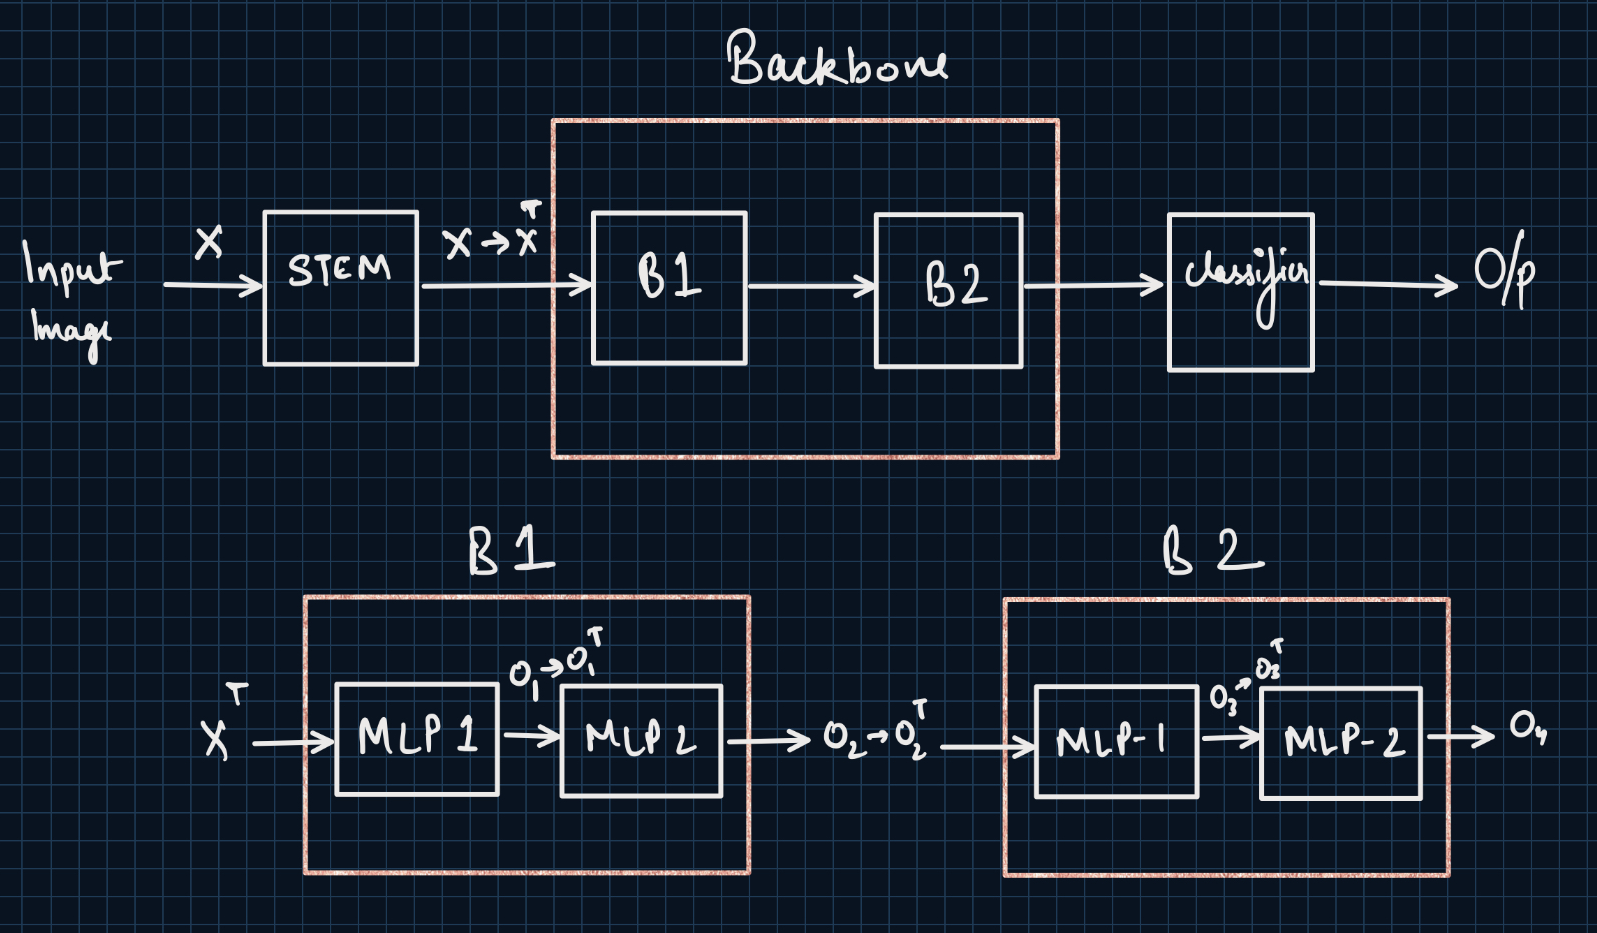

# Part 3: Create the Loss and optimizer

## Loss Function

* Using PyTorch's implementation of Softmax-Cross Entropy loss to avoid numerical instabilities.
Cross-entropy loss is used when adjusting model weights during training. The aim is to minimize the loss, i.e, the smaller the loss the better the model. 




In [ ]:
loss = nn.CrossEntropyLoss()

## Optimization Algorithm

Adam optimization algorithm is an extension to stochastic gradient descent to update network weights iterative based in training data. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

Adam optimizer is used with a default learning rate of 0.001 and algorithms default betas values provide better rate of convergence as other algorithms like SGD, and ASGD doesn't perform equally well on the given problem.



In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0005, eps=1e-08)

## Adding a Scheduler

The job of the Pytorch scheduler is to adjust he learning rate when the accuracy loss curve becomes constant. The varying learning rate helps in better fit and train the model which results in a better accuracy of the model.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience= 50)

# Evaluation


In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [ ]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X = X.to(device)  # transferring our tensors to GPU
        y = y.to(device)   
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

* The accuracy of the model prior to training should be close to random guessing, i.e., 0.1 for 10 classes.


In [ ]:

evaluate_accuracy(net, test_iter)

0.0991

# Part 4: Training the model

* The following function trains the model (`net`) on a training set (`train_iter`) for `num_epochs`.
* At the end of each epoch, the model is evaluated on a testing set (`test_iter`).
* `Animator` for visualizing the training progress.

In [ ]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=128, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X = X.to(device)  # transferring our tensors to GPU
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Evaluating the data using net.eval() in the below function to compute the testing loss.
net.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. As we are using Dropouts Layers, BatchNorm Layers in the backbone of the model, we are truning them off during evaluation on the test data.

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler): 
    """Train a model."""
    max_test_acc = 0
    max_acc_epoch = 0
    animator = mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    valid_loss = 0
    net.eval()
    for data, label in test_iter:
      data = data.to(device)  # transferring our tensors to GPU
      label = label.to(device)
      target = net(data)
      valid_step_loss = loss(target, label)
      valid_loss += valid_step_loss.item() * data.size(0)

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        print("Epoch {}: ".format(epoch + 1))
        print("Training Metrics: {}".format(train_metrics))
        print("Test Accuracy: {} %".format(test_acc*100))
        
        if test_acc > max_test_acc:
          max_test_acc = test_acc
          max_acc_epoch = epoch+1
        print("The Maximum test accuracy:  {} at epoch: {}".format(max_test_acc*100, max_acc_epoch))
        animator.add(epoch + 1, train_metrics + (test_acc,))

        # adding a scheduler to adjust learning rates while training
        if scheduler:
          scheduler.step(valid_loss/len(test_iter))

        else:
          for param_group in optimizer.param_groups:
            param_group['lr']= scheduler(epoch)

    train_loss, train_acc = train_metrics
    return max_test_acc, train_loss, train_acc, test_acc

# Part 5: Training and plotting Final Model Accuracy



Final Training Metric: Loss: 0.017355572019020715, Train Accuracy 99.68 %
Final Test Accuracy: 88.63%
Best test accuracy achieved: 89.58%


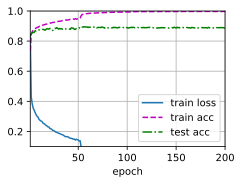

In [ ]:
num_epochs = 200
test_accuracy, train_loss, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler)
print("Final Training Metric: Loss: {}, Train Accuracy {} %".format(train_loss, train_acc*100))
print("Final Test Accuracy: {}%".format(test_acc*100))
print("Best test accuracy achieved: {}%".format(test_accuracy*100))